<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch4_8~9_pg_252~277_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 머신러닝 완벽가이드 ch4.8 ~ 9 pg.252 ~ 277 필사

## CH04.08 분류 실습 - 캐글 산탄데르 고객 만족 예측 (XGBoost와 LightGBM 활용하여 예측)
: 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하기

- 클래스 레이블 명 : TARGET (1 = 불만 고객 / 0 = 만족 고객)

- 성능 평가 : ROC-AUC 곡선

### 데이터 전처리 : 필요한 모듈 로딩, 학습 데이터를 DataFrame으로 로딩

- XGBoost : 사이킷런 래퍼 이용

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("C:/Users/park jihyun/Desktop/대학교 5학기 자료/ESAA 학회/9_분류 세션 자료/santander-customer-satisfaction/train_santander.csv", encoding="latin-1")
print('dataset shape:', cust_df.shape)   #클래스 값 칼럼 포함한 피처가 371개 존재
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
# 피처의 타입과 Null 값 알아보기
cust_df.info()   #111개 피처 : float형 / 260개 피처 : int형 > 모든 피처 숫자형
#Null값 X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
# 전체 데이터에서 만족과 불만족(+Target의) 비율 실표보기
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))
# 불만족인 고객 4%

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
# 각 피처의 값 분포 확인하기
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
# 'var3'에서 -99999값 116개 존재 > -99999를 최빈값 2로 변환해주기
cust_df['var3'].replace(-99999, 2, inplace=True)
# 단순 식별자인 ID 피처 드롭하기
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split
# 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트 분리하기
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

# 비대칭 데이터 세트 > 학습/테스트 데이터 세트에 모두 비슷하게 추출되었는지 확인하기
print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)
# 원본 데이터와 유사하게 전체 데이터의 4% 불만족값 가지고 있음

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

- XGBoost의 학습 모델 생성하고 예측 결과 ROC AUC로 평가하기

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82005	validation_1-auc:0.81163
[1]	validation_0-auc:0.83400	validation_1-auc:0.82457
[2]	validation_0-auc:0.83870	validation_1-auc:0.82748
[3]	validation_0-auc:0.84419	validation_1-auc:0.82925
[4]	validation_0-auc:0.84786	validation_1-auc:0.83301
[5]	validation_0-auc:0.85150	validation_1-auc:0.83457
[6]	validation_0-auc:0.85468	validation_1-auc:0.83603
[7]	validation_0-auc:0.85832	validation_1-auc:0.83773
[8]	validation_0-auc:0.86124	validation_1-auc:0.83915
[9]	validation_0-auc:0.86461	validation_1-auc:0.84070
[10]	validation_0-auc:0.86733	validation_1-auc:0.84159
[11]	validation_0-auc:0.86992	validation_1-auc:0.84219
[12]	validation_0-auc:0.87259	validation_1-auc:0.84194
[13]	validation_0-auc:0.87586	validation_1-auc:0.84155
[14]	validation_0-auc:0.87884	validation_1-auc:0.84316
[15]	validation_0-auc:0.88130	validation_1-auc:0.84273
[16]	validation_0-auc:0.88272	validation_1-auc:0.84202
[17]	validation_0-auc:0.88409	validation_1-auc:0.84263
[18]	validation_0-au

- XGBoost의 하이퍼 파라미터 튜닝 수행하기
: 칼럼 개수 많으므로 과적합 가능성 가정, 몇 하이퍼 파라미터만 일차 튜닝 대상으로 하기

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79161	validation_1-auc:0.79321
[1]	validation_0-auc:0.81865	validation_1-auc:0.81375
[2]	validation_0-auc:0.82586	validation_1-auc:0.81846
[3]	validation_0-auc:0.82789	validation_1-auc:0.82226
[4]	validation_0-auc:0.83249	validation_1-auc:0.82677
[5]	validation_0-auc:0.83477	validation_1-auc:0.83225
[6]	validation_0-auc:0.83340	validation_1-auc:0.82654
[7]	validation_0-auc:0.84223	validation_1-auc:0.83487
[8]	validation_0-auc:0.84586	validation_1-auc:0.83682
[9]	validation_0-auc:0.84557	validation_1-auc:0.83472
[10]	validation_0-auc:0.84423	validation_1-auc:0.83181
[11]	validation_0-auc:0.84428	validation_1-auc:0.82920
[12]	validation_0-auc:0.85176	validation_1-auc:0.83433
[13]	validation_0-auc:0.85540	validation_1-auc:0.83565
[14]	validation_0-auc:0.85719	validation_1-auc:0.83696
[15]	validation_0-auc:0.85849	validation_1-auc:0.83561
[16]	validation_0-auc:0.85964	validation_1-auc:0.83578
[17]	validation_0-auc:0.86092	validation_1-auc:0.83570
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80013	validation_1-auc:0.79686
[1]	validation_0-auc:0.82084	validation_1-auc:0.81574
[2]	validation_0-auc:0.82744	validation_1-auc:0.82189
[3]	validation_0-auc:0.83029	validation_1-auc:0.82317
[4]	validation_0-auc:0.83578	validation_1-auc:0.82564
[5]	validation_0-auc:0.83777	validation_1-auc:0.83385
[6]	validation_0-auc:0.83741	validation_1-auc:0.83162
[7]	validation_0-auc:0.84373	validation_1-auc:0.83436
[8]	validation_0-auc:0.84836	validation_1-auc:0.83664
[9]	validation_0-auc:0.84790	validation_1-auc:0.83583
[10]	validation_0-auc:0.84717	validation_1-auc:0.83268
[11]	validation_0-auc:0.84653	validation_1-auc:0.83066
[12]	validation_0-auc:0.85377	validation_1-auc:0.83578
[13]	validation_0-auc:0.85799	validation_1-auc:0.83859
[14]	validation_0-auc:0.85962	validation_1-auc:0.83984
[15]	validation_0-auc:0.86143	validation_1-auc:0.84006
[16]	validation_0-auc:0.86296	validation_1-auc:0.84069
[17]	validation_0-auc:0.86428	validation_1-auc:0.84024
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80039	validation_1-auc:0.80013
[1]	validation_0-auc:0.82111	validation_1-auc:0.82026
[2]	validation_0-auc:0.82749	validation_1-auc:0.82627
[3]	validation_0-auc:0.83124	validation_1-auc:0.82830
[4]	validation_0-auc:0.83475	validation_1-auc:0.82881
[5]	validation_0-auc:0.83677	validation_1-auc:0.83385
[6]	validation_0-auc:0.83648	validation_1-auc:0.83085
[7]	validation_0-auc:0.84336	validation_1-auc:0.83472
[8]	validation_0-auc:0.84624	validation_1-auc:0.83404
[9]	validation_0-auc:0.84541	validation_1-auc:0.83287
[10]	validation_0-auc:0.84555	validation_1-auc:0.83039
[11]	validation_0-auc:0.84525	validation_1-auc:0.82995
[12]	validation_0-auc:0.85144	validation_1-auc:0.83489
[13]	validation_0-auc:0.85525	validation_1-auc:0.83803
[14]	validation_0-auc:0.85746	validation_1-auc:0.84145
[15]	validation_0-auc:0.85818	validation_1-auc:0.84082
[16]	validation_0-auc:0.86005	validation_1-auc:0.84075
[17]	validation_0-auc:0.86126	validation_1-auc:0.84139
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79210	validation_1-auc:0.79292
[1]	validation_0-auc:0.81759	validation_1-auc:0.81404
[2]	validation_0-auc:0.82567	validation_1-auc:0.81864
[3]	validation_0-auc:0.82819	validation_1-auc:0.82244
[4]	validation_0-auc:0.83233	validation_1-auc:0.82618
[5]	validation_0-auc:0.83480	validation_1-auc:0.83163
[6]	validation_0-auc:0.83342	validation_1-auc:0.82840
[7]	validation_0-auc:0.84265	validation_1-auc:0.83512
[8]	validation_0-auc:0.84614	validation_1-auc:0.83742
[9]	validation_0-auc:0.84573	validation_1-auc:0.83475
[10]	validation_0-auc:0.84426	validation_1-auc:0.83066
[11]	validation_0-auc:0.84358	validation_1-auc:0.82936
[12]	validation_0-auc:0.85089	validation_1-auc:0.83491
[13]	validation_0-auc:0.85457	validation_1-auc:0.83785
[14]	validation_0-auc:0.85644	validation_1-auc:0.83894
[15]	validation_0-auc:0.85744	validation_1-auc:0.83784
[16]	validation_0-auc:0.85870	validation_1-auc:0.83899
[17]	validation_0-auc:0.86002	validation_1-auc:0.83854
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79931	validation_1-auc:0.79594
[1]	validation_0-auc:0.81987	validation_1-auc:0.81503
[2]	validation_0-auc:0.82734	validation_1-auc:0.82126
[3]	validation_0-auc:0.83110	validation_1-auc:0.82302
[4]	validation_0-auc:0.83608	validation_1-auc:0.82494
[5]	validation_0-auc:0.83914	validation_1-auc:0.83100
[6]	validation_0-auc:0.83828	validation_1-auc:0.82999
[7]	validation_0-auc:0.84425	validation_1-auc:0.83439
[8]	validation_0-auc:0.84749	validation_1-auc:0.83609
[9]	validation_0-auc:0.84727	validation_1-auc:0.83597
[10]	validation_0-auc:0.84704	validation_1-auc:0.83250
[11]	validation_0-auc:0.84663	validation_1-auc:0.83237
[12]	validation_0-auc:0.85343	validation_1-auc:0.83713
[13]	validation_0-auc:0.85671	validation_1-auc:0.83887
[14]	validation_0-auc:0.85824	validation_1-auc:0.83919
[15]	validation_0-auc:0.85963	validation_1-auc:0.83905
[16]	validation_0-auc:0.86088	validation_1-auc:0.84031
[17]	validation_0-auc:0.86214	validation_1-auc:0.84051
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80248	validation_1-auc:0.80001
[1]	validation_0-auc:0.82249	validation_1-auc:0.81765
[2]	validation_0-auc:0.82833	validation_1-auc:0.82524
[3]	validation_0-auc:0.83372	validation_1-auc:0.82814
[4]	validation_0-auc:0.83653	validation_1-auc:0.82856
[5]	validation_0-auc:0.83838	validation_1-auc:0.83345
[6]	validation_0-auc:0.83823	validation_1-auc:0.83165
[7]	validation_0-auc:0.84386	validation_1-auc:0.83505
[8]	validation_0-auc:0.84688	validation_1-auc:0.83507
[9]	validation_0-auc:0.84634	validation_1-auc:0.83484
[10]	validation_0-auc:0.84564	validation_1-auc:0.83324
[11]	validation_0-auc:0.84501	validation_1-auc:0.83284
[12]	validation_0-auc:0.85011	validation_1-auc:0.83692
[13]	validation_0-auc:0.85299	validation_1-auc:0.83995
[14]	validation_0-auc:0.85524	validation_1-auc:0.84250
[15]	validation_0-auc:0.85609	validation_1-auc:0.84183
[16]	validation_0-auc:0.85747	validation_1-auc:0.84319
[17]	validation_0-auc:0.85894	validation_1-auc:0.84363
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80843	validation_1-auc:0.80885
[1]	validation_0-auc:0.82920	validation_1-auc:0.82211
[2]	validation_0-auc:0.83320	validation_1-auc:0.82400
[3]	validation_0-auc:0.83624	validation_1-auc:0.82577
[4]	validation_0-auc:0.84145	validation_1-auc:0.82827
[5]	validation_0-auc:0.84425	validation_1-auc:0.83317
[6]	validation_0-auc:0.84455	validation_1-auc:0.82823
[7]	validation_0-auc:0.85368	validation_1-auc:0.83175
[8]	validation_0-auc:0.85904	validation_1-auc:0.83544
[9]	validation_0-auc:0.85884	validation_1-auc:0.82847
[10]	validation_0-auc:0.85896	validation_1-auc:0.82719
[11]	validation_0-auc:0.85949	validation_1-auc:0.82626
[12]	validation_0-auc:0.86533	validation_1-auc:0.82899
[13]	validation_0-auc:0.86994	validation_1-auc:0.83274
[14]	validation_0-auc:0.87186	validation_1-auc:0.83340
[15]	validation_0-auc:0.87292	validation_1-auc:0.83077
[16]	validation_0-auc:0.87471	validation_1-auc:0.83213
[17]	validation_0-auc:0.87646	validation_1-auc:0.83230
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81304	validation_1-auc:0.81746
[1]	validation_0-auc:0.82857	validation_1-auc:0.82037
[2]	validation_0-auc:0.83592	validation_1-auc:0.82473
[3]	validation_0-auc:0.84019	validation_1-auc:0.82830
[4]	validation_0-auc:0.84741	validation_1-auc:0.83134
[5]	validation_0-auc:0.84928	validation_1-auc:0.83593
[6]	validation_0-auc:0.85103	validation_1-auc:0.83169
[7]	validation_0-auc:0.85820	validation_1-auc:0.83472
[8]	validation_0-auc:0.86362	validation_1-auc:0.83639
[9]	validation_0-auc:0.86354	validation_1-auc:0.83551
[10]	validation_0-auc:0.86388	validation_1-auc:0.83128
[11]	validation_0-auc:0.86436	validation_1-auc:0.83000
[12]	validation_0-auc:0.87121	validation_1-auc:0.83415
[13]	validation_0-auc:0.87563	validation_1-auc:0.83763
[14]	validation_0-auc:0.87817	validation_1-auc:0.83812
[15]	validation_0-auc:0.88024	validation_1-auc:0.83620
[16]	validation_0-auc:0.88253	validation_1-auc:0.83769
[17]	validation_0-auc:0.88407	validation_1-auc:0.83832
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81393	validation_1-auc:0.81377
[1]	validation_0-auc:0.82962	validation_1-auc:0.82668
[2]	validation_0-auc:0.83724	validation_1-auc:0.83017
[3]	validation_0-auc:0.84075	validation_1-auc:0.83079
[4]	validation_0-auc:0.84691	validation_1-auc:0.83337
[5]	validation_0-auc:0.84896	validation_1-auc:0.83502
[6]	validation_0-auc:0.84980	validation_1-auc:0.82858
[7]	validation_0-auc:0.85918	validation_1-auc:0.83358
[8]	validation_0-auc:0.86284	validation_1-auc:0.83470
[9]	validation_0-auc:0.86364	validation_1-auc:0.83427
[10]	validation_0-auc:0.86242	validation_1-auc:0.83265
[11]	validation_0-auc:0.86248	validation_1-auc:0.83255
[12]	validation_0-auc:0.86974	validation_1-auc:0.83514
[13]	validation_0-auc:0.87456	validation_1-auc:0.83759
[14]	validation_0-auc:0.87635	validation_1-auc:0.83922
[15]	validation_0-auc:0.87827	validation_1-auc:0.83671
[16]	validation_0-auc:0.87991	validation_1-auc:0.83844
[17]	validation_0-auc:0.88292	validation_1-auc:0.83803
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80901	validation_1-auc:0.80653
[1]	validation_0-auc:0.82713	validation_1-auc:0.82150
[2]	validation_0-auc:0.83227	validation_1-auc:0.82513
[3]	validation_0-auc:0.83319	validation_1-auc:0.82525
[4]	validation_0-auc:0.83790	validation_1-auc:0.82809
[5]	validation_0-auc:0.84101	validation_1-auc:0.82978
[6]	validation_0-auc:0.84424	validation_1-auc:0.82639
[7]	validation_0-auc:0.85310	validation_1-auc:0.83443
[8]	validation_0-auc:0.85884	validation_1-auc:0.83779
[9]	validation_0-auc:0.85896	validation_1-auc:0.83430
[10]	validation_0-auc:0.85668	validation_1-auc:0.83222
[11]	validation_0-auc:0.85720	validation_1-auc:0.83070
[12]	validation_0-auc:0.86275	validation_1-auc:0.83549
[13]	validation_0-auc:0.86757	validation_1-auc:0.83728
[14]	validation_0-auc:0.86937	validation_1-auc:0.83912
[15]	validation_0-auc:0.87029	validation_1-auc:0.83611
[16]	validation_0-auc:0.87161	validation_1-auc:0.83649
[17]	validation_0-auc:0.87323	validation_1-auc:0.83643
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81176	validation_1-auc:0.80947
[1]	validation_0-auc:0.82655	validation_1-auc:0.82282
[2]	validation_0-auc:0.83553	validation_1-auc:0.82708
[3]	validation_0-auc:0.83839	validation_1-auc:0.82857
[4]	validation_0-auc:0.84789	validation_1-auc:0.82941
[5]	validation_0-auc:0.84959	validation_1-auc:0.83339
[6]	validation_0-auc:0.84942	validation_1-auc:0.83011
[7]	validation_0-auc:0.85460	validation_1-auc:0.83382
[8]	validation_0-auc:0.85909	validation_1-auc:0.83679
[9]	validation_0-auc:0.85877	validation_1-auc:0.83719
[10]	validation_0-auc:0.85812	validation_1-auc:0.83426
[11]	validation_0-auc:0.85860	validation_1-auc:0.83445
[12]	validation_0-auc:0.86505	validation_1-auc:0.83817
[13]	validation_0-auc:0.86857	validation_1-auc:0.83993
[14]	validation_0-auc:0.87130	validation_1-auc:0.84097
[15]	validation_0-auc:0.87263	validation_1-auc:0.83901
[16]	validation_0-auc:0.87444	validation_1-auc:0.83891
[17]	validation_0-auc:0.87535	validation_1-auc:0.83920
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81519	validation_1-auc:0.81115
[1]	validation_0-auc:0.83201	validation_1-auc:0.82366
[2]	validation_0-auc:0.83717	validation_1-auc:0.83029
[3]	validation_0-auc:0.84145	validation_1-auc:0.83163
[4]	validation_0-auc:0.84628	validation_1-auc:0.83410
[5]	validation_0-auc:0.84792	validation_1-auc:0.83694
[6]	validation_0-auc:0.84780	validation_1-auc:0.83116
[7]	validation_0-auc:0.85600	validation_1-auc:0.83760
[8]	validation_0-auc:0.85905	validation_1-auc:0.83700
[9]	validation_0-auc:0.85861	validation_1-auc:0.83638
[10]	validation_0-auc:0.85874	validation_1-auc:0.83594
[11]	validation_0-auc:0.85930	validation_1-auc:0.83694
[12]	validation_0-auc:0.86567	validation_1-auc:0.84079
[13]	validation_0-auc:0.86948	validation_1-auc:0.84373
[14]	validation_0-auc:0.87107	validation_1-auc:0.84539
[15]	validation_0-auc:0.87174	validation_1-auc:0.84460
[16]	validation_0-auc:0.87353	validation_1-auc:0.84501
[17]	validation_0-auc:0.87468	validation_1-auc:0.84437
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81007	validation_1-auc:0.80693
[1]	validation_0-auc:0.82137	validation_1-auc:0.81877
[2]	validation_0-auc:0.82976	validation_1-auc:0.82498
[3]	validation_0-auc:0.83120	validation_1-auc:0.82212
[4]	validation_0-auc:0.83382	validation_1-auc:0.82481
[5]	validation_0-auc:0.83696	validation_1-auc:0.82672
[6]	validation_0-auc:0.83976	validation_1-auc:0.83016
[7]	validation_0-auc:0.84177	validation_1-auc:0.83329
[8]	validation_0-auc:0.84585	validation_1-auc:0.83282
[9]	validation_0-auc:0.84985	validation_1-auc:0.83519
[10]	validation_0-auc:0.85146	validation_1-auc:0.83530
[11]	validation_0-auc:0.85113	validation_1-auc:0.83380
[12]	validation_0-auc:0.85502	validation_1-auc:0.83622
[13]	validation_0-auc:0.85797	validation_1-auc:0.83644
[14]	validation_0-auc:0.85990	validation_1-auc:0.83686
[15]	validation_0-auc:0.86114	validation_1-auc:0.83639
[16]	validation_0-auc:0.86159	validation_1-auc:0.83602
[17]	validation_0-auc:0.86284	validation_1-auc:0.83501
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80863	validation_1-auc:0.80011
[1]	validation_0-auc:0.82349	validation_1-auc:0.81717
[2]	validation_0-auc:0.82654	validation_1-auc:0.81737
[3]	validation_0-auc:0.82988	validation_1-auc:0.82281
[4]	validation_0-auc:0.83570	validation_1-auc:0.82554
[5]	validation_0-auc:0.83917	validation_1-auc:0.82930
[6]	validation_0-auc:0.84492	validation_1-auc:0.83396
[7]	validation_0-auc:0.84657	validation_1-auc:0.83569
[8]	validation_0-auc:0.84837	validation_1-auc:0.83476
[9]	validation_0-auc:0.85009	validation_1-auc:0.83841
[10]	validation_0-auc:0.85017	validation_1-auc:0.83887
[11]	validation_0-auc:0.85091	validation_1-auc:0.83724
[12]	validation_0-auc:0.85584	validation_1-auc:0.83976
[13]	validation_0-auc:0.85900	validation_1-auc:0.84063
[14]	validation_0-auc:0.86060	validation_1-auc:0.84054
[15]	validation_0-auc:0.86168	validation_1-auc:0.84086
[16]	validation_0-auc:0.86304	validation_1-auc:0.84085
[17]	validation_0-auc:0.86382	validation_1-auc:0.83947
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82005	validation_1-auc:0.81815
[1]	validation_0-auc:0.82547	validation_1-auc:0.82159
[2]	validation_0-auc:0.83019	validation_1-auc:0.82631
[3]	validation_0-auc:0.83229	validation_1-auc:0.82660
[4]	validation_0-auc:0.83488	validation_1-auc:0.82988
[5]	validation_0-auc:0.83888	validation_1-auc:0.83262
[6]	validation_0-auc:0.84242	validation_1-auc:0.83408
[7]	validation_0-auc:0.84581	validation_1-auc:0.83560
[8]	validation_0-auc:0.84775	validation_1-auc:0.83617
[9]	validation_0-auc:0.84989	validation_1-auc:0.83746
[10]	validation_0-auc:0.85052	validation_1-auc:0.83816
[11]	validation_0-auc:0.84982	validation_1-auc:0.83603
[12]	validation_0-auc:0.85408	validation_1-auc:0.83826
[13]	validation_0-auc:0.85547	validation_1-auc:0.83955
[14]	validation_0-auc:0.85818	validation_1-auc:0.84292
[15]	validation_0-auc:0.85990	validation_1-auc:0.84361
[16]	validation_0-auc:0.86142	validation_1-auc:0.84287
[17]	validation_0-auc:0.86246	validation_1-auc:0.84280
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81104	validation_1-auc:0.80637
[1]	validation_0-auc:0.82008	validation_1-auc:0.81881
[2]	validation_0-auc:0.82922	validation_1-auc:0.82532
[3]	validation_0-auc:0.83159	validation_1-auc:0.82594
[4]	validation_0-auc:0.83378	validation_1-auc:0.82618
[5]	validation_0-auc:0.83671	validation_1-auc:0.82887
[6]	validation_0-auc:0.84111	validation_1-auc:0.83302
[7]	validation_0-auc:0.84227	validation_1-auc:0.83380
[8]	validation_0-auc:0.84422	validation_1-auc:0.83346
[9]	validation_0-auc:0.84742	validation_1-auc:0.83582
[10]	validation_0-auc:0.84984	validation_1-auc:0.83563
[11]	validation_0-auc:0.84933	validation_1-auc:0.83344
[12]	validation_0-auc:0.85285	validation_1-auc:0.83653
[13]	validation_0-auc:0.85493	validation_1-auc:0.83796
[14]	validation_0-auc:0.85653	validation_1-auc:0.83880
[15]	validation_0-auc:0.85803	validation_1-auc:0.83841
[16]	validation_0-auc:0.85923	validation_1-auc:0.83772
[17]	validation_0-auc:0.85983	validation_1-auc:0.83709
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81067	validation_1-auc:0.81109
[1]	validation_0-auc:0.82045	validation_1-auc:0.81627
[2]	validation_0-auc:0.82760	validation_1-auc:0.82116
[3]	validation_0-auc:0.82925	validation_1-auc:0.81730
[4]	validation_0-auc:0.83628	validation_1-auc:0.82554
[5]	validation_0-auc:0.83889	validation_1-auc:0.82992
[6]	validation_0-auc:0.84258	validation_1-auc:0.83304
[7]	validation_0-auc:0.84516	validation_1-auc:0.83327
[8]	validation_0-auc:0.84797	validation_1-auc:0.83479
[9]	validation_0-auc:0.84982	validation_1-auc:0.83737
[10]	validation_0-auc:0.84996	validation_1-auc:0.83746
[11]	validation_0-auc:0.84929	validation_1-auc:0.83715
[12]	validation_0-auc:0.85506	validation_1-auc:0.83957
[13]	validation_0-auc:0.85817	validation_1-auc:0.84131
[14]	validation_0-auc:0.85946	validation_1-auc:0.84041
[15]	validation_0-auc:0.86040	validation_1-auc:0.83984
[16]	validation_0-auc:0.86126	validation_1-auc:0.83954
[17]	validation_0-auc:0.86170	validation_1-auc:0.83947
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81835	validation_1-auc:0.81692
[1]	validation_0-auc:0.82862	validation_1-auc:0.82346
[2]	validation_0-auc:0.83280	validation_1-auc:0.82893
[3]	validation_0-auc:0.83563	validation_1-auc:0.82931
[4]	validation_0-auc:0.83780	validation_1-auc:0.83200
[5]	validation_0-auc:0.83975	validation_1-auc:0.83280
[6]	validation_0-auc:0.84205	validation_1-auc:0.83374
[7]	validation_0-auc:0.84453	validation_1-auc:0.83256
[8]	validation_0-auc:0.84638	validation_1-auc:0.83384
[9]	validation_0-auc:0.84986	validation_1-auc:0.83670
[10]	validation_0-auc:0.85058	validation_1-auc:0.83825
[11]	validation_0-auc:0.84986	validation_1-auc:0.83646
[12]	validation_0-auc:0.85321	validation_1-auc:0.83744
[13]	validation_0-auc:0.85479	validation_1-auc:0.83942
[14]	validation_0-auc:0.85614	validation_1-auc:0.84092
[15]	validation_0-auc:0.85710	validation_1-auc:0.84170
[16]	validation_0-auc:0.85892	validation_1-auc:0.84238
[17]	validation_0-auc:0.86024	validation_1-auc:0.84215
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81685	validation_1-auc:0.81075
[1]	validation_0-auc:0.82791	validation_1-auc:0.82283
[2]	validation_0-auc:0.83537	validation_1-auc:0.82615
[3]	validation_0-auc:0.83996	validation_1-auc:0.82712
[4]	validation_0-auc:0.84558	validation_1-auc:0.82791
[5]	validation_0-auc:0.84781	validation_1-auc:0.82977
[6]	validation_0-auc:0.85151	validation_1-auc:0.83373
[7]	validation_0-auc:0.85510	validation_1-auc:0.83453
[8]	validation_0-auc:0.85996	validation_1-auc:0.83602
[9]	validation_0-auc:0.86243	validation_1-auc:0.83834
[10]	validation_0-auc:0.86449	validation_1-auc:0.83482
[11]	validation_0-auc:0.86492	validation_1-auc:0.83100
[12]	validation_0-auc:0.87031	validation_1-auc:0.83352
[13]	validation_0-auc:0.87428	validation_1-auc:0.83408
[14]	validation_0-auc:0.87588	validation_1-auc:0.83527
[15]	validation_0-auc:0.87798	validation_1-auc:0.83333
[16]	validation_0-auc:0.87975	validation_1-auc:0.83372
[17]	validation_0-auc:0.88061	validation_1-auc:0.83262
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81432	validation_1-auc:0.80561
[1]	validation_0-auc:0.82773	validation_1-auc:0.81858
[2]	validation_0-auc:0.83520	validation_1-auc:0.82197
[3]	validation_0-auc:0.84268	validation_1-auc:0.82757
[4]	validation_0-auc:0.84815	validation_1-auc:0.83068
[5]	validation_0-auc:0.85346	validation_1-auc:0.83319
[6]	validation_0-auc:0.85971	validation_1-auc:0.83530
[7]	validation_0-auc:0.86284	validation_1-auc:0.83831
[8]	validation_0-auc:0.86543	validation_1-auc:0.83884
[9]	validation_0-auc:0.86785	validation_1-auc:0.84067
[10]	validation_0-auc:0.86895	validation_1-auc:0.84079
[11]	validation_0-auc:0.86889	validation_1-auc:0.83763
[12]	validation_0-auc:0.87444	validation_1-auc:0.83969
[13]	validation_0-auc:0.87848	validation_1-auc:0.83798
[14]	validation_0-auc:0.88016	validation_1-auc:0.83964
[15]	validation_0-auc:0.88263	validation_1-auc:0.83991
[16]	validation_0-auc:0.88413	validation_1-auc:0.84062
[17]	validation_0-auc:0.88476	validation_1-auc:0.84051
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82507	validation_1-auc:0.81932
[1]	validation_0-auc:0.83077	validation_1-auc:0.82081
[2]	validation_0-auc:0.83704	validation_1-auc:0.82829
[3]	validation_0-auc:0.84184	validation_1-auc:0.83011
[4]	validation_0-auc:0.84747	validation_1-auc:0.83438
[5]	validation_0-auc:0.85319	validation_1-auc:0.83489
[6]	validation_0-auc:0.85706	validation_1-auc:0.83487
[7]	validation_0-auc:0.86253	validation_1-auc:0.83489
[8]	validation_0-auc:0.86436	validation_1-auc:0.83406
[9]	validation_0-auc:0.86657	validation_1-auc:0.83491
[10]	validation_0-auc:0.86829	validation_1-auc:0.83443
[11]	validation_0-auc:0.86897	validation_1-auc:0.83444
[12]	validation_0-auc:0.87502	validation_1-auc:0.83502
[13]	validation_0-auc:0.87832	validation_1-auc:0.83536
[14]	validation_0-auc:0.88111	validation_1-auc:0.83748
[15]	validation_0-auc:0.88265	validation_1-auc:0.83845
[16]	validation_0-auc:0.88496	validation_1-auc:0.83678
[17]	validation_0-auc:0.88674	validation_1-auc:0.83637
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81664	validation_1-auc:0.81074
[1]	validation_0-auc:0.83122	validation_1-auc:0.82620
[2]	validation_0-auc:0.83368	validation_1-auc:0.82978
[3]	validation_0-auc:0.83631	validation_1-auc:0.82844
[4]	validation_0-auc:0.83973	validation_1-auc:0.82929
[5]	validation_0-auc:0.84469	validation_1-auc:0.83164
[6]	validation_0-auc:0.85029	validation_1-auc:0.83263
[7]	validation_0-auc:0.85460	validation_1-auc:0.83312
[8]	validation_0-auc:0.85808	validation_1-auc:0.83513
[9]	validation_0-auc:0.86156	validation_1-auc:0.83608
[10]	validation_0-auc:0.86348	validation_1-auc:0.83393
[11]	validation_0-auc:0.86450	validation_1-auc:0.83101
[12]	validation_0-auc:0.86797	validation_1-auc:0.83297
[13]	validation_0-auc:0.87027	validation_1-auc:0.83379
[14]	validation_0-auc:0.87201	validation_1-auc:0.83416
[15]	validation_0-auc:0.87402	validation_1-auc:0.83454
[16]	validation_0-auc:0.87505	validation_1-auc:0.83339
[17]	validation_0-auc:0.87549	validation_1-auc:0.83294
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81435	validation_1-auc:0.81418
[1]	validation_0-auc:0.82683	validation_1-auc:0.81889
[2]	validation_0-auc:0.83600	validation_1-auc:0.82603
[3]	validation_0-auc:0.83951	validation_1-auc:0.82593
[4]	validation_0-auc:0.84599	validation_1-auc:0.83184
[5]	validation_0-auc:0.84952	validation_1-auc:0.83242
[6]	validation_0-auc:0.85562	validation_1-auc:0.83685
[7]	validation_0-auc:0.85908	validation_1-auc:0.83671
[8]	validation_0-auc:0.86286	validation_1-auc:0.83685
[9]	validation_0-auc:0.86509	validation_1-auc:0.84035
[10]	validation_0-auc:0.86421	validation_1-auc:0.83964
[11]	validation_0-auc:0.86544	validation_1-auc:0.83511
[12]	validation_0-auc:0.86962	validation_1-auc:0.83989
[13]	validation_0-auc:0.87441	validation_1-auc:0.84002
[14]	validation_0-auc:0.87596	validation_1-auc:0.83998
[15]	validation_0-auc:0.87751	validation_1-auc:0.84059
[16]	validation_0-auc:0.87821	validation_1-auc:0.84068
[17]	validation_0-auc:0.87940	validation_1-auc:0.83966
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82297	validation_1-auc:0.81707
[1]	validation_0-auc:0.83141	validation_1-auc:0.82133
[2]	validation_0-auc:0.83805	validation_1-auc:0.82785
[3]	validation_0-auc:0.84271	validation_1-auc:0.82902
[4]	validation_0-auc:0.84766	validation_1-auc:0.83398
[5]	validation_0-auc:0.85126	validation_1-auc:0.83381
[6]	validation_0-auc:0.85486	validation_1-auc:0.83360
[7]	validation_0-auc:0.85944	validation_1-auc:0.83287
[8]	validation_0-auc:0.86243	validation_1-auc:0.83187
[9]	validation_0-auc:0.86501	validation_1-auc:0.83304
[10]	validation_0-auc:0.86496	validation_1-auc:0.83318
[11]	validation_0-auc:0.86466	validation_1-auc:0.83180
[12]	validation_0-auc:0.87013	validation_1-auc:0.83453
[13]	validation_0-auc:0.87319	validation_1-auc:0.83548
[14]	validation_0-auc:0.87479	validation_1-auc:0.83833
[15]	validation_0-auc:0.87618	validation_1-auc:0.83862
[16]	validation_0-auc:0.87739	validation_1-auc:0.83927
[17]	validation_0-auc:0.87883	validation_1-auc:0.83904
[18]	validation_0-au

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81712	validation_1-auc:0.81271
[1]	validation_0-auc:0.82826	validation_1-auc:0.82280
[2]	validation_0-auc:0.83310	validation_1-auc:0.82684
[3]	validation_0-auc:0.83751	validation_1-auc:0.83103
[4]	validation_0-auc:0.84106	validation_1-auc:0.83200
[5]	validation_0-auc:0.84328	validation_1-auc:0.83326
[6]	validation_0-auc:0.84670	validation_1-auc:0.83462
[7]	validation_0-auc:0.84952	validation_1-auc:0.83560
[8]	validation_0-auc:0.85125	validation_1-auc:0.83756
[9]	validation_0-auc:0.85473	validation_1-auc:0.84003
[10]	validation_0-auc:0.85522	validation_1-auc:0.84139
[11]	validation_0-auc:0.85463	validation_1-auc:0.83872
[12]	validation_0-auc:0.85945	validation_1-auc:0.84096
[13]	validation_0-auc:0.86156	validation_1-auc:0.84218
[14]	validation_0-auc:0.86302	validation_1-auc:0.84377
[15]	validation_0-auc:0.86443	validation_1-auc:0.84367
[16]	validation_0-auc:0.86521	validation_1-auc:0.84351
[17]	validation_0-auc:0.86646	validation_1-auc:0.84337
[18]	validation_0-au

> 결과 : 최적 파라미터 :


- 앞서 구한 최적화 하이퍼 파라미터 기반으로 다른 하이퍼 파라미터 변경/추가해 다시 최적화 진행하기
 - n_estimators와 learning_rate, reg_alpha를 추가/변경하여 XGBoost를 학습시킨 뒤 ROC AUC 구하기

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함.
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 200으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73501	validation_1-auc:0.74128
[1]	validation_0-auc:0.82359	validation_1-auc:0.81776
[2]	validation_0-auc:0.81094	validation_1-auc:0.80194
[3]	validation_0-auc:0.81288	validation_1-auc:0.80637
[4]	validation_0-auc:0.82564	validation_1-auc:0.81831
[5]	validation_0-auc:0.83065	validation_1-auc:0.82196
[6]	validation_0-auc:0.83608	validation_1-auc:0.82734
[7]	validation_0-auc:0.83832	validation_1-auc:0.82902
[8]	validation_0-auc:0.84104	validation_1-auc:0.83114
[9]	validation_0-auc:0.84000	validation_1-auc:0.83020
[10]	validation_0-auc:0.84155	validation_1-auc:0.83071
[11]	validation_0-auc:0.84090	validation_1-auc:0.82996
[12]	validation_0-auc:0.84176	validation_1-auc:0.83039
[13]	validation_0-auc:0.83976	validation_1-auc:0.82916
[14]	validation_0-auc:0.84155	validation_1-auc:0.83015
[15]	validation_0-auc:0.84440	validation_1-auc:0.83236
[16]	validation_0-auc:0.84484	validation_1-auc:0.83261
[17]	validation_0-auc:0.84462	validation_1-auc:0.83207
[18]	validation_0-au

결과 : 조금 더 향상된 결과
- 앙상블 계열 알고리즘 : 과적합/잡음에 기본적으로 뛰어난 알고리즘 > 하이퍼 파라미터 튜닝으로 성능 수치 개선 급격히 되는 경우 많지 않음



- 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내기
 - xgboost모듈의 plot_importance() 메서드 사용하기

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

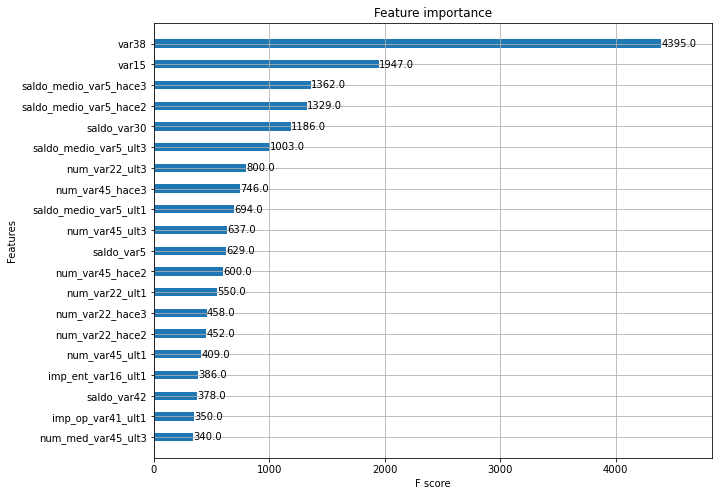

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

> 결과 : 예측 성능 좌우하는 가장 중요한 피처 : var38, var15 순이다.

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

XGBoost의 데이터 세트 기반으로 LightGBM으로 학습을 수행하고, ROC-AUC를 측정하기

In [ ]:
from re import X
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.83419	valid_0's binary_logloss: 0.149407
[7]	valid_0's auc: 0.837155	valid_0's binary_logloss: 0.147942
[8]	valid_0's auc: 0.837996	valid_0's binary_logloss: 0.146565
[9]	valid_0's auc: 0.839603	valid_0's binary_logloss: 0.145427
[10]	valid_0's auc: 0.839867	valid_0's binary_logloss: 0.14447
[11]	valid_0's auc: 0.839887	valid_0's binary_logloss: 0.14375
[12]	valid_0's auc: 0.839856	valid_0's binary_logloss: 0.143201
[13]	valid_0's auc: 0.839997	valid_0's binary_logloss: 0.142632
[14]	valid_0's auc: 0.840001	valid_0's binary_logloss: 0.142149
[15]	valid_0's auc: 0.84079	valid_0's binary_logloss: 0.14171
[16]	valid_0's auc: 0.840096	valid_0's binary_logloss:

- GridSearchCV로 좀 더 다양한 하이퍼 파라미터에 대한 튜닝 수행하기

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 삼소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32, 64],
          'max_depth': [128, 160],
          'min_child_samples':[60,100],
          'subsample':[0.8, 1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train, y_train), (X_test, y_test)])

print("GridSearchCV 최적 파라미터:", gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.83587	training's binary_logloss: 0.15528	valid_1's auc: 0.820192	valid_1's binary_logloss: 0.164812
[2]	training's auc: 0.843305	training's binary_logloss: 0.149401	valid_1's auc: 0.826488	valid_1's binary_logloss: 0.159486
[3]	training's auc: 0.850605	training's binary_logloss: 0.145058	valid_1's auc: 0.833867	valid_1's binary_logloss: 0.155607
[4]	training's auc: 0.857473	training's binary_logloss: 0.141712	valid_1's auc: 0.835902	valid_1's binary_logloss: 0.15279
[5]	training's auc: 0.862215	training's binary_logloss: 0.138906	valid_1's auc: 0.837887	valid_1's binary_logloss: 0.150685
[6]	training's auc: 0.866046	training's binary_logloss: 0.136564	valid_1's auc: 0.83821	valid_1's binary_logloss: 0.148674
[7]	training's auc: 0.867545	training's binary_logloss: 0.134563	valid_1's auc: 0.838396	valid_1's binary_logloss: 0.147187
[8]	training's auc: 0.869699	training's binary_logloss: 0.132769	valid_1's auc: 0.839675	valid_1's binary_logloss: 0.145756
[9]	training

- 해당 하이퍼 파라미터는 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과 도출하기

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\park jihyun\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.141254
[16]	valid_0's auc: 0.841108	valid_0's binary_logloss: 0

## CH04.09. 분류 실습 - 캐글 신용카드 사기 검출

**해당 데이터 세트의 레이블인 Class 속성 : 매우 불균형한 분포**

0 = 정상적인 신용카드 트랜잭션 데이터 / 1 = 사기 트랜잭션

(사기와 같은 이상현상: 전체 데이터에서 차지하는 비중 매우 적을 수밖에 없음)

### 언더 샘플링과 오버 샘플링의 이해
: 레이블이 불균형한 분포 가진 데이터 세트 학습시킬 때 예측 성능 문제 발생 < 일반적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출 어려워지기 쉬움

**해결방안**
- 오버 샘플링(Oversampling) : 주로 사용, 이상 데이터와 같인 적은 데이터 세트를 증식하여 학습에 충분한 데이터 확보하는 방법 (과적합 방지<원본 데이터의 피처 값을을 아주 약간만 변경하여 증식함)
    - SMOTE 방법 : 적은 데이터 세트의 개별 데이터들의 K 최근접 이웃 찾아서 이 데이터와 K 이웃들의 차이를 일정 값으로 만들어 시존 데이터와 약간 차이가 나는 새로운 데이터 생성하는 방식
- 언더 샘플링(Undersampling) : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식 (but, 많은 양을 가지고 있었던 정상 레이블의 경우 오히려 제대로 된 학습 수행 X)

In [ ]:
#SMOTE 구현한 파이썬 패키지 imbalanced-learn 설치하기
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


### 데이터 일차 가공 및 모델 학습/예측/평가

- 데이터 세트 로딩하고 신용카드 사기 검출 모델 생성하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv("C:/Users/park jihyun/Desktop/대학교 5학기 자료/ESAA 학회/9_분류 세션 자료/archive/creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


**피처 설명**

- V 시작 피처 : 의미 알 수 X
- Time 피처 : 데이터 생성 관련 작업용 속성 > 제거
- Amount 피처 : 신용카드 트랜잭션 금액
- Class : 레이블, 0 = 정상 / 1= 사기 트랜잭션

card_df.info() : 전체 레코드에서 결측치 X, Class: int형 / 나머지 :float형

**다양한 데이터 사전 가공 수행, 이에 따른 예측 성능 함께 비교하기**
- 인자로 입력된 DataFrame 복사 후 가공하여 반환하는 함수, 데이터 가공 후 학습/테스트 세트 반환하는 함수 생성하기

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 압력받은 DataFrame을 복사한 뒤 TIme 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 ㅅ사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame으 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

- 생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하게 분할되었는지 확인하기

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


> 결과 : 큰 차이 없이 잘 분할됨

- 모델 생성하기 : 로지스틱 회귀, LightGBM 기반 모델이 데이터 가공 수행하면서 예측 성능 어떻게 변하는지 살펴보기
    - 로지스틱 회귀를 이용한 신용 카드 사기 여부 예측하기

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

# 3장의 get_clf_eval() 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,     F1: 0.7149, AUC:0.9592


- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트 입력 받아 학습/예측/평가를 하는 함수 생성하기 > 반복적으로 모델 변경해 학습/예측/평가할 것이므로 필요!

In [ ]:
# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

- LightGBM으로 모델 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가 수행하기

극도로 불균형한 레이블 값 분포 > **LGBMClassifier 객체 생성 시, boost_from_average=False**로 파라미터 설정하기
: boost_from_average=True의 불균형한 데이터세트에서 재현률 및 ROC-AUC 성능 크게 저하 방지 위해 필요

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,     F1: 0.8453, AUC:0.9790


> 결과 : 앞의 로지스틱 회귀보다 높은 수치 나타냄

### 데이터 분포도 변환 후 모델 학습/예측/평가
: 왜곡된 분포도 가지는 데이터를 재가공한 뒤 모델 다시 테스트하기

- creditcard.csv의 중요 피처 Amount 피처값의 분포도 살펴보기

대부분의 선형 모델: 중요 피처들의 값이 정규 분포 형태 유지하는 것을 선호함

<AxesSubplot:xlabel='Amount', ylabel='Density'>

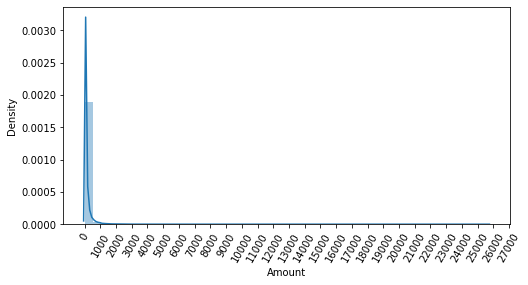

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

> 결과 : Amount=카드 사용금액의 분포 : 꼬리가 긴 형태의 분포 곡선

- Amount를 표준 정규 분포 형태로 변환한 뒤 로지스틱 회귀의 예측 성능 측정하기

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞의 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
! pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


- 함수 수정 후 get_train_test_dataset() 호출해 학습/테스트 데이터 세트를 생성한 뒤에 get_model_train_eval() 이용해 로지스틱 회귀와 LightBGM 모델을 각각 학습/쳬측/평가하기

In [ ]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("## 로지스틱 회귀 예측 성능 ##")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

print("## LightGBM 예측 성능 ##")
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)


## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,     F1: 0.7143, AUC:0.9702
## LightGBM 예측 성능 ##
오차 행렬
[[85146   149]
 [   81    67]]
정확도: 0.9973, 정밀도: 0.3102, 재현율: 0.4527,     F1: 0.3681, AUC:0.7253


- 데이터 가공 함수인 get_preprocessed_df()를 로그변환(데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나) 로직으로 변경하기

In [ ]:
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy["Amount"])
  df_copy.insert(0, "Amount_Scaled", amount_n)
  df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
  return df_copy

- Amount 피처를 로그 변환 후 다시 로지스틱 회귀와 LightGBM 모델을 적용 후 예측 성능을 확인하기

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("## 로지스틱 회귀 예측 성능 ##")
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

print("## LightGBM 예측 성능 ##")
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train,
                    tgt_test = y_test)

## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,     F1: 0.7149, AUC:0.9727
## LightGBM 예측 성능 ##
오차 행렬
[[85238    57]
 [   77    71]]
정확도: 0.9984, 정밀도: 0.5547, 재현율: 0.4797,     F1: 0.5145, AUC:0.7395


### 이상치 데이터 제거 후 모델 학습/예측/평가

<AxesSubplot:>

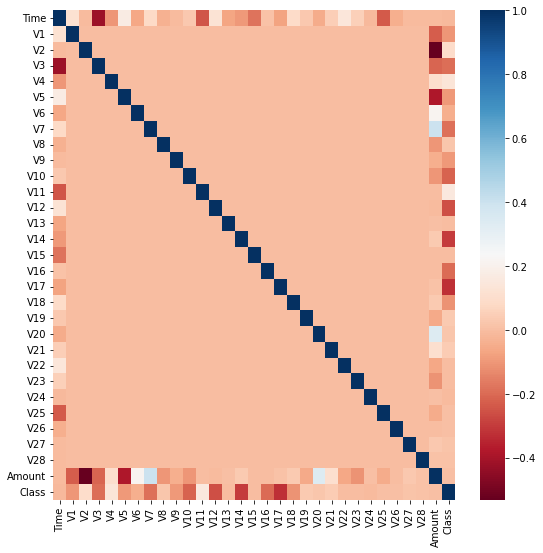

In [ ]:
import seaborn as sns

plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap = "RdBu")

In [ ]:
import numpy as np

def get_outlier(df = None, column = None, weight = 1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함.
  fraud = df[df["Class"] == 1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [ ]:
outlier_index = get_outlier(df = card_df, column = "V14", weight = 1.5)
print("이상치 데이터 인덱스: ", outlier_index)

이상치 데이터 인덱스:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [ ]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy["Amount"])
  df_copy.insert(0, "Amount_Scaled", amount_n)
  df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df = df_copy, column = "V14", weight = 1.5)
  df_copy.drop(outlier_index, axis = 0, inplace = True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print("## 로지스틱 회귀 예측 성능 ##")
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,     F1: 0.7597, AUC:0.9743


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ", X_train.shape, y_train.shape)
print("SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ", X_train_over.shape, y_train_over.shape)
print("SMOTE 적용 후 레이블 값 분포: \n", pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [ ]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over,
                     tgt_test = y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,     F1: 0.1023, AUC:0.9737


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

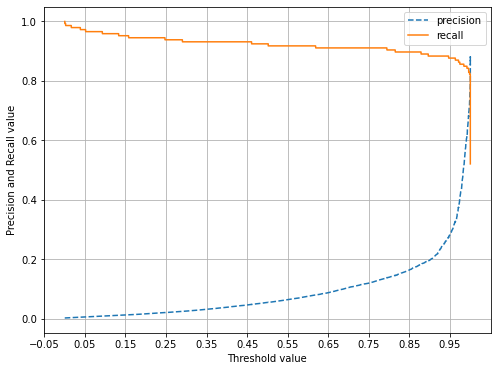

In [ ]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test,
                     tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,     F1: 0.8794, AUC:0.9814
